## Visualize WoFCast Predictions

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# Set this lower, to allow for PyTorch Model to fit into memory
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.95' 
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import sys, os 
package_path = os.path.dirname(os.path.dirname(os.getcwd())) 
print(f'{package_path=}')
sys.path.insert(0, package_path)
from glob import glob 

from wofscast.model import WoFSCastModel
from wofscast.data_generator import load_chunk, dataset_to_input, add_local_solar_time
from wofscast.common.wofs_data_loader import WoFSDataLoader
from wofscast.common.wofs_analysis_loader import WoFSAnalysisLoader

# For the diffusion model. 
from wofscast.diffusion import DiffusionModel 

# Utils for loading data, plotting, animations. 
from wofscast.common.mrms_data_loader import MRMSDataLoader 
from wofscast.common.helpers import (get_case_date, 
                                     to_datetimes, 
                                     get_qpe_datetimes, 
                                     border_difference_check,
                                     compute_nmep, 
                                     convert_rain_amount_to_inches, 
                                     convert_T2_K_to_F
                                    ) 
from wofscast.common.plot_utils import WoFSCastAnimator 
from dataclasses import dataclass

# To display the animation in a Jupyter notebook
from IPython.display import HTML

# For plotting. 
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

package_path='/home/monte.flora/python_packages/frdd-wofs-cast'


## Configuration for Plotting, Data loading, Model Loading

In [10]:
# This configuration class contains all the user-settings required to run this notebook. 
year = '2021'
# For the legacy v178 model.
base_path = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/'
fname = 'wrfwof_2021-05-15_020000_to_2021-05-15_041000__10min__ens_mem_09.zarr'
#fname = 'wrfwof_2021-05-27_000000_to_2021-05-27_021000__10min__ens_mem_09.zarr'

#fname = 'wrfwof_2021-05-15_020000_to_2021-05-15_041000__10min__ens_mem_01.zarr'
#base_path = '/work2/mflora/wofscast_datasets/dataset_10min_15min_init/'
#fname = 'wrfwof_2021-05-15_001500_to_2021-05-15_022500__10min__ens_mem_09.zarr'

#base_path = '/work2/mflora/wofscast_datasets/dataset_30min_fixed/'
#fname = 'wrfwof_2021-05-14_234500_to_2021-05-15_021500__30min__ens_mem_09.zarr'

# For full-domain
#base_path = '/work2/mflora/wofscast_datasets/dataset_10min_full_domain_test/'
#fname = 'wrfwof_2021-05-28_000000_to_2021-05-28_021000__10min__ens_mem_09.zarr'

data_path = os.path.join(base_path, year, fname)

@dataclass
class VisualizationConfig :
    save_animations = True
    
    # Path to the WoFSCast model weights.
    model_path = '/work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz'
    #model_path = '/work/mflora/wofs-cast-data/model/wofscast_test_30min.npz'
    #model_path = '/work/mflora/wofs-cast-data/model/wofscast_10min_model_noise_v1.npz'
 
    #model_path =  '/work2/mflora/wofs-cast-data/model/wofscast_test_v178_fine_tune_v3.npz'

    # Whether to load all ensemble members. 
    load_ensemble = False
    
    timestep = 10 
    steps_per_hour = 60 // timestep # 60 min / 5 min time steps
    hours = 6
    n_steps = int(steps_per_hour * hours)
    
    year = '2021'
    mem = 9 
    
    # List of pandas datetime objects for plotting the time step. 
    dts = to_datetimes(data_path, n_times = n_steps+2)
    
    resize = False if 'full_domain' in data_path else True
    
    full_domain = True if 'full_domain' in data_path else False
    
    decode_times = True 
  
config = VisualizationConfig()
config.domain_size = 300 if config.full_domain else 150

legacy_models = [
    '/work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz',
    '/work2/mflora/wofs-cast-data/model/wofscast_test_v178_fine_tune_v3.npz'
]

preprocess_fn = None
additional_configs={}
if config.model_path in legacy_models:
    preprocess_fn = add_local_solar_time
    config.decode_times = False
    additional_configs = {"legacy_mesh" : False}

## Generate WoFS-Cast Predictions 

In [11]:
%%time 
model = WoFSCastModel()



if config.full_domain:
    model.load_model(config.model_path, **{'tiling' : (2,2)})
else:    
    model.load_model(config.model_path, **additional_configs)

data_loader = WoFSDataLoader(config, model.task_config, 
                             preprocess_fn, 
                             config.load_ensemble, 
                            config.decode_times)     
    
inputs, targets, forcings = data_loader.load_inputs_targets_forcings(data_path)
    
predictions = model.predict(inputs, targets, forcings, 
                            initial_datetime=config.dts[0], 
                            n_steps=config.n_steps,
                            replace_bdry=False)

# 18-mem 2hr ensemble prediction on 1 GPU: 39.6 s 

Adding forcing variables using add_local_solar_time
model_config.legacy_mesh=False
Enforcing consistent face orientation
Correcting the bi-direction mesh edges
CPU times: user 39.7 s, sys: 2.92 s, total: 42.6 s
Wall time: 7.59 s


## Generate WoFS-Cast Prediction with Diffusion Applied In-step 

## Apply diffusion in-post to the WoFSCast predictions

## Load MRMS Data. 

In [12]:
loader = MRMSDataLoader(data_loader.case_date, config.dts, 
                        domain_size=config.domain_size, 
                        resize_domain=config.resize)
mrms_dz = loader.load() 

## Load the WoFS Analysis 

In [13]:
# Load the WoFS analysis files for verification. 
anal_loader = WoFSAnalysisLoader(config.domain_size, config.resize)
var = 'COMPOSITE_REFL_10CM'
anal_ds = anal_loader.load(var, config.dts, config.year, data_loader.case_date, config.mem)

## Compute NMEP for select variables (optional)

In [14]:
if config.load_ensemble: 

    predictions = compute_nmep(predictions, 'COMPOSITE_REFL_10CM', 40.0)
    targets = compute_nmep(targets, 'COMPOSITE_REFL_10CM', 40.0)
    inputs = compute_nmep(inputs, 'COMPOSITE_REFL_10CM', 40.0)

    predictions = compute_nmep(predictions, 'RAIN_AMOUNT', 0.5)
    targets = compute_nmep(targets, 'RAIN_AMOUNT', 0.5)
    inputs = compute_nmep(inputs, 'RAIN_AMOUNT', 0.5)

In [15]:
# Convert units 
unit_converter_funcs = [convert_T2_K_to_F, convert_rain_amount_to_inches]

for func in unit_converter_funcs:
    predictions = func(predictions)
    targets = func(targets)
    inputs = func(inputs)

## Animate WoFS vs. WoFSCast 

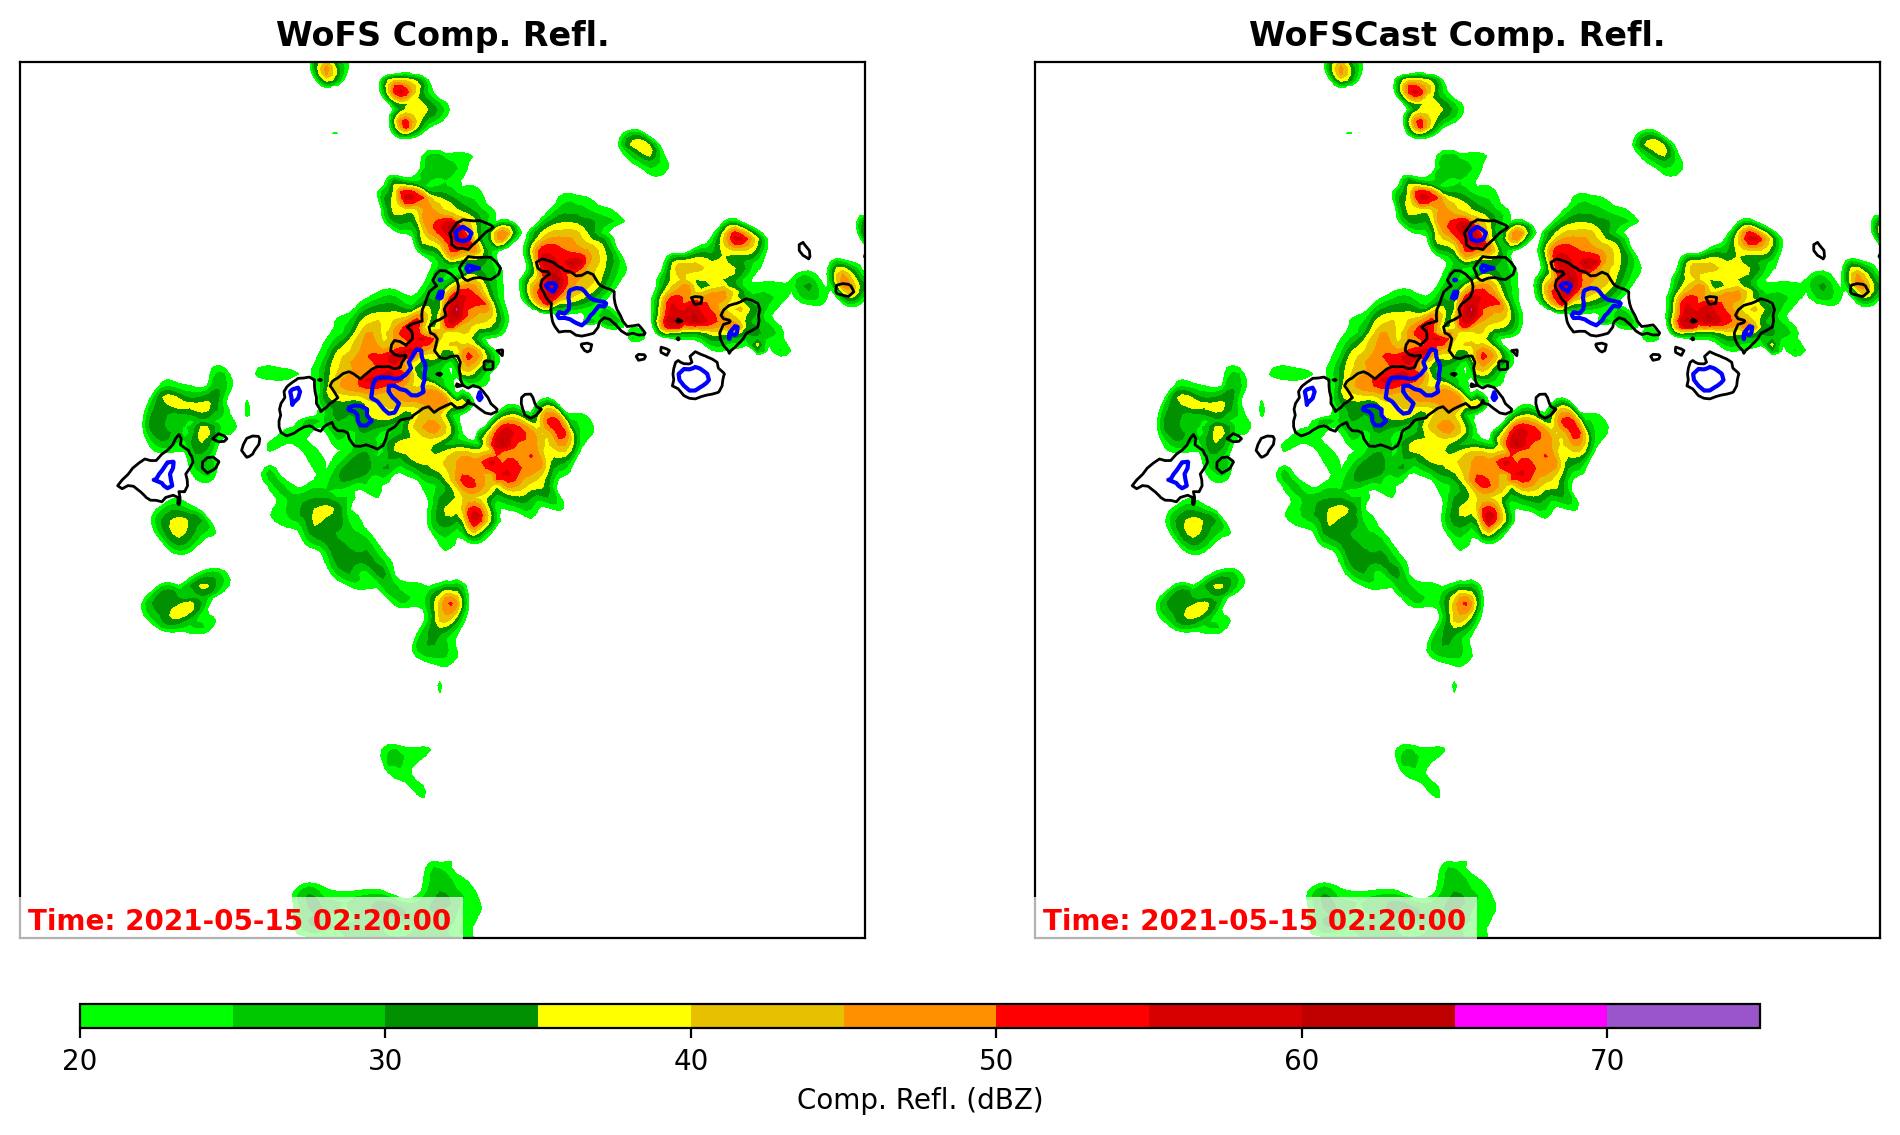

In [16]:
animator = WoFSCastAnimator(
    inputs, 
    predictions, 
    targets, 
    mrms_dz, 
    domain_size = config.domain_size,
    dts = config.dts, 
    add_rmse = False, 
    for_randy=False,
    add_timing_text=False
)

var='COMPOSITE_REFL_10CM'

anim = animator.create_animation(var, level='none', ens_idx = 0,#config.mem, 
                                 animation_type = 'wofs_vs_wofscast')

if config.save_animations: 
    #Optionally, to save the animation
    anim.save(f"gifs/wofscast_10min_{var}_{config.hours}hrs_full_domain.gif", 
              writer="pillow", fps=3)

HTML(anim.to_jshtml())

## Raw WoFSCast vs. WoFSCast with Diffusion 

In [9]:
animator = WoFSCastAnimator(
    inputs, 
    predictions_with_diff, 
    predictions, 
    mrms_dz, 
    domain_size = config.domain_size,
    dts = config.dts, 
    add_rmse = True, 
    for_randy=False,
    title_prefixes = ['WoFSCast', 'WoFSCastDiff']
)

var='COMPOSITE_REFL_10CM'

anim = animator.create_animation(var, level='none', ens_idx = 0,#config.mem, 
                                 animation_type = 'wofs_vs_wofscast')

if config.save_animations: 
    #Optionally, to save the animation
    anim.save(f"gifs/wofscast_10min_{var}_6hrs_full_domain.gif", 
              writer="pillow", fps=3)

HTML(anim.to_jshtml())

NameError: name 'predictions_with_diff' is not defined

## Animate WoFS, WoFSCast, WoFS Analysis, and MRMS Reflectivity

In [ ]:

var='T2'

# Load the WoFS analysis files for verification. 
anal_loader = WoFSAnalysisLoader(config.domain_size, config.resize)
anal_ds = anal_loader.load(var, config.dts, config.year, data_loader.case_date, config.mem)

animator = WoFSCastAnimator(
    inputs, 
    predictions, 
    targets, 
    mrms_dz, 
    anal_ds,
    domain_size = config.domain_size,
    dts = config.dts, 
    add_rmse = True, 
    for_randy=False,
)


anim = animator.create_animation(var, level='none', 
                                 animation_type = 'wofs_wofscast_analysis_mrms')

if config.save_animations: 
    #Optionally, to save the animation
    anim.save(f"gifs/wofscast_10min_{var}_6hrs_full_domain.gif", 
              writer="pillow", fps=3)

HTML(anim.to_jshtml())

## Animate Ensemble Probabilities 

In [ ]:
animator = WoFSCastAnimator(
    inputs, 
    predictions, 
    targets, 
    mrms_dz, 
    domain_size = config.domain_size,
    dts = config.dts, 
    add_rmse = True, 
    for_randy=False,
)

var='COMPOSITE_REFL_10CM_nmep'
anim = animator.create_animation(var, level='none', 
                                 animation_type = 'wofs_vs_wofscast')

if config.save_animations: 
    #Optionally, to save the animation
    anim.save(f"gifs/wofscast_10min_{var}_6hrs_full_domain.gif", 
              writer="pillow", fps=3)

HTML(anim.to_jshtml())